In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import pickle

In [3]:
vb = pd.read_csv("../data/vb_data_3_numZone.csv")

In [4]:
q_values_raw = pickle.load(open('../output/q_values_new.pkl', 'rb'))
q_values = np.asarray([q_values_raw[i,0] for i in range(len(q_values_raw))])
y_prob_tree = pickle.load(open('../output/y_probabilities_tree.pkl', 'rb'))
q_tree = y_prob_tree[:,1]*2 - 1

q_values_adj = q_values.copy()
q_values_adj[np.abs(q_values) > 1] = np.sign(q_values_adj[np.abs(q_values) > 1])

### Box plot of Q values

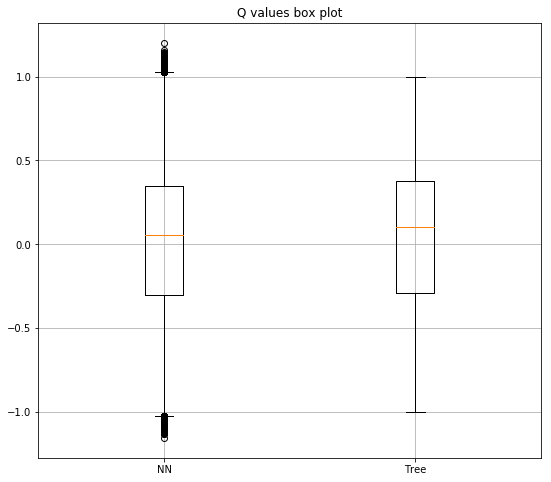

Ratio of NN Q values outside [-1.05, 1.05] interval: 0.0048


In [9]:
import matplotlib.pyplot as plt
data = [q_values, q_tree]
plt.figure(figsize=(9,8))
plt.title('Q values box plot')
plt.grid(True)
plt.boxplot(data, labels=('NN','Tree'), whis=[1,99])
plt.show()

threshold = 1.05
cond = (np.abs(q_values) > threshold)
print('Ratio of NN Q values outside [-%.2f, %.2f] interval: %.4f' % (threshold, threshold, sum(cond)/len(q_values)))

In [94]:
print('Total for   NN:   mean: %.4f,   max: %.4f,   min: %.4f' % (np.mean(q_values), np.max(q_values), np.min(q_values)))
print('Total for Tree:   mean: %.4f,   max: %.4f,   min: %.4f' % (np.mean(q_tree), np.max(q_tree), np.min(q_tree)))

#print(np.mean(q_values) - np.mean(q_tree))
#q_values_adj = q_values - np.mean(q_values) + np.mean(q_tree)

print('\nTotal average for serve action from data: %.4f' % (np.mean(vb.RewardValue[vb.ActionType0=='S'])))
print('Total average for serve action for NN: %.4f' % (np.mean(q_values[vb.ActionType0=='S'])))
print('Total average for serve action for Tree : %.4f' % (np.mean(q_tree[vb.ActionType0=='S'])))

Total for   NN:   mean: 0.0241,   max: 1.2025,   min: -1.1552
Total for Tree:   mean: 0.0348,   max: 1.0000,   min: -1.0000

Total average for serve action from data: 0.0257
Total average for serve action for NN: 0.0145
Total average for serve action for Tree : 0.0257


### Action outcome breakdown

In [100]:
for action in ['S','R','E','A','B','D']:
    print('\nHome ' + action)
    for outcome in ['=','/','-','!','+','#']:
        cond = (vb['ActionType0']==action) & (vb['ActionHome0']==1) & (vb['ActionOutcome0']==outcome)
        if (sum(cond) > 0):
            print('%s: avg Q %.3f for tree, %.3f for neural net, %.3f from data' % \
              (outcome, np.mean(q_tree[cond], axis=0), np.mean(q_values[cond], axis=0), np.mean(vb.RewardValue[cond], axis=0)))


Home S
=: avg Q -1.000 for tree, -0.997 for neural net, -1.000 from data
-: avg Q -0.293 for tree, -0.304 for neural net, -0.293 from data
!: avg Q 0.103 for tree, -0.116 for neural net, -0.106 from data
+: avg Q 0.103 for tree, 0.207 for neural net, 0.238 from data
#: avg Q 1.000 for tree, 0.995 for neural net, 1.000 from data

Home R
=: avg Q -1.000 for tree, -0.998 for neural net, -1.000 from data
-: avg Q -0.167 for tree, -0.178 for neural net, -0.166 from data
!: avg Q 0.104 for tree, 0.091 for neural net, 0.118 from data
+: avg Q 0.287 for tree, 0.301 for neural net, 0.321 from data
#: avg Q 0.437 for tree, 0.414 for neural net, 0.447 from data

Home E
=: avg Q -0.941 for tree, -0.995 for neural net, -1.000 from data
-: avg Q -0.080 for tree, -0.229 for neural net, -0.187 from data
+: avg Q 0.364 for tree, 0.339 for neural net, 0.372 from data
#: avg Q 0.317 for tree, 0.295 for neural net, 0.316 from data

Home A
=: avg Q -0.991 for tree, -0.995 for neural net, -1.000 from data


### Accuracy as a classifier

In [6]:
from sklearn import metrics
tree_pred = np.sign(np.sign(q_tree)+0.01)
nn_pred = np.sign(q_values)
print("Accuracy Tree:", metrics.accuracy_score(tree_pred, vb.RewardValue))
print("Accuracy NN:", metrics.accuracy_score(nn_pred, vb.RewardValue))
print("Accuracy difference:", metrics.accuracy_score(nn_pred, vb.RewardValue)-metrics.accuracy_score(tree_pred, vb.RewardValue))
#print("Accuracy adjusted NN:", metrics.accuracy_score(np.sign(q_values_adj), vb.RewardValue))

Accuracy Tree: 0.7492571037315988
Accuracy NN: 0.7533242040397125
Accuracy difference: 0.004067100308113636


In [122]:
print('When NN as classifier is wrong:')
cond = (nn_pred != vb.RewardValue) #& (tree_pred == vb.RewardValue)
print(sum(cond), 'cases')
#print('Tree mean abs error:', np.mean(np.abs(q_tree[cond]-vb.RewardValue[cond])))
print('NN mean abs error:', np.mean(np.abs(q_values[cond]-vb.RewardValue[cond])))
print('NN max abs error:', np.max(np.abs(q_values[cond]-vb.RewardValue[cond])))
print('\nWhen Tree as classifier is wrong:')
cond = (tree_pred != vb.RewardValue) #& (nn_pred == vb.RewardValue)
print(sum(cond), 'cases')
#print('NN mean abs error:', np.mean(np.abs(q_values[cond]-vb.RewardValue[cond])))
print('Tree mean abs error:', np.mean(np.abs(q_tree[cond]-vb.RewardValue[cond])))
print('Tree max abs error:', np.max(np.abs(q_tree[cond]-vb.RewardValue[cond])))

When NN as classifier is wrong:
36027 cases
NN mean abs error: 1.219121639399241
NN max abs error: 1.84950852394104

When Tree as classifier is wrong:
36621 cases
Tree mean abs error: 1.2224767168712547
Tree max abs error: 1.968503937007874


In [131]:
print('Tree:')
print(metrics.confusion_matrix(vb.RewardValue, np.sign(np.sign(q_tree)+0.01), normalize='true'))
print('\nNN:')
print(metrics.confusion_matrix(vb.RewardValue, np.sign(q_values), normalize='true'))
#print('\nAdjusted NN:')
#print(metrics.confusion_matrix(vb.RewardValue, np.sign(q_values_adj)))

Tree:
[[0.7076074  0.2923926 ]
 [0.21189424 0.78810576]]

NN:
[[0.73781284 0.26218716]
 [0.23220761 0.76779239]]


### Distance from end of rally analysis

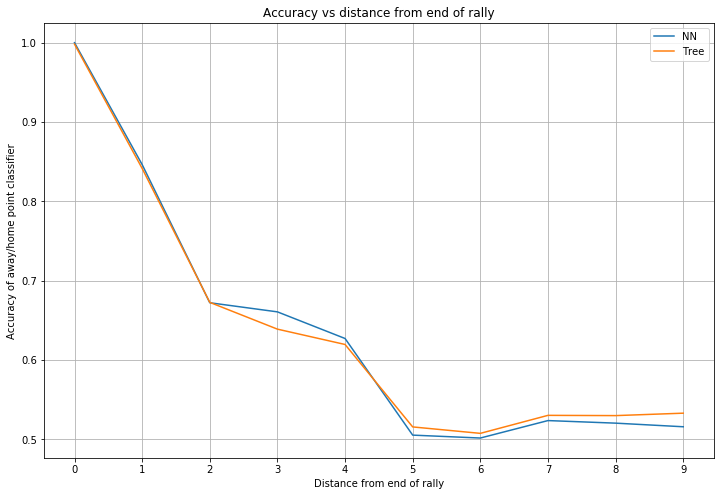

In [10]:
accs_nn = []
accs_tree = []
for dist in range(0,10):
    cond = (vb.RewardDistance == dist)
    #print('\nTree accuracy for distance %d: %.4f' % (dist, metrics.accuracy_score(tree_pred[cond], vb.RewardValue[cond])))
    #print('NN accuracy for distance %d: %.4f' % (dist, metrics.accuracy_score(nn_pred[cond], vb.RewardValue[cond])))
    accs_tree.append(metrics.accuracy_score(tree_pred[cond], vb.RewardValue[cond]))
    accs_nn.append(metrics.accuracy_score(nn_pred[cond], vb.RewardValue[cond]))
plt.figure(figsize=(12,8))
plt.title('Accuracy vs distance from end of rally')
plt.grid(True)
plt.xticks(range(0,10))
plt.xlabel('Distance from end of rally')
plt.ylabel('Accuracy of away/home point classifier')
plt.plot(range(0,10), accs_nn)
plt.plot(range(0,10), accs_tree)
plt.legend(['NN','Tree'])
plt.show()